# Simple FEM for an elastic plate with a hole

## Create a mesh for the plate with hole

First we need to build the geometry. The shape and mesh is generated with pygmsh, exported to a vtk file that can be visualized with ParaView, and then imported for use in scikit-fem. 

<skfem MeshTri1 object>
  Number of elements: 3070
  Number of vertices: 1612
  Number of nodes: 1612
  Named boundaries [# facets]: right [40], left [20], bottom [20], top [40]


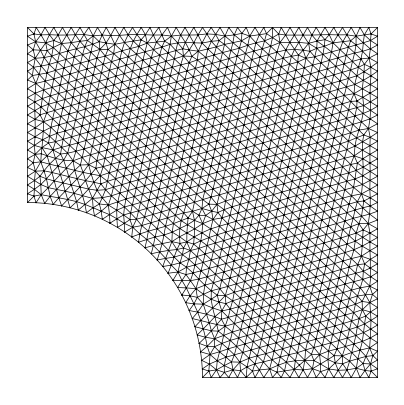

In [1]:
import copy 
import pygmsh
import numpy as np
import skfem as fem
from skfem.helpers import ddot, dot, eye, sym_grad, trace
from skfem.visuals.matplotlib import draw, plot

from global_constants import EPS0, LBD, MU, B0, L, R, RATIO

# Element size
N = 40
s = L / N

# Ellipse dimensions
Rx = 0.5
Ry = R**2 / Rx
Rz = 1.0

# Build geometry and export mesh
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = s
    rectangle = geom.add_rectangle([0.0, 0.0, 0.0], a=L, b=L)
    hole = geom.add_ellipsoid([0, 0, 0.0], [Rx, Ry, Rz])
    geom.boolean_difference(rectangle, hole)
    m = geom.generate_mesh()
    m.write("mesh.vtk")

# Convert to scikit-fem mesh
mesh = fem.MeshTet().load("mesh.vtk")

# Label boundaries
mesh = mesh.with_boundaries(
    {
        "right": lambda x: x[0] == L,
        "left": lambda x: x[0] <= 0.001,
        "bottom": lambda x: x[1] <= 0.001,
        "top": lambda x: x[1] == L,
    }
)

# Visualize the mesh
draw(mesh, figsize=(5, 5))
print(mesh)

## Create the FEM function space

In [2]:
# Define first order triangles and define a 2d variable on it (u1 and u2)
element = fem.ElementVector(fem.ElementTriP1(), 2)
# Function space
basis = fem.Basis(mesh, element)

## Material model

A single 2D ply stiffness tensor is given as 

$$
\sigma = 2\mu \nabla^s u + \lambda \textrm{tr}(\nabla^s u)I
$$

In [3]:
def sigma(eps):
    return  2.0 * MU * eps + LBD * eye(trace(eps), 2)

## Bilinear form of the weak form

$$ \int_\Omega \sigma \left [\nabla^s u \right] \cdot \nabla^s v dV = \int_\Omega f \cdot v dV $$

In [4]:
@fem.BilinearForm
def k(u, v, w):
    return ddot(sigma(sym_grad(u)), sym_grad(v))

@fem.LinearForm
def b(v, w):
    f = np.zeros(v.shape)
    f[0, :, :] = B0
    return dot(f, v)

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Right: 

$$ u_1 = \varepsilon_0 L\\  
   u_2 =0
$$

In [5]:
# Get all degrees of freedom and set appropiate entry to prescribed BCs.
u = basis.zeros()
u[basis.get_dofs({"right"}).nodal['u^1']] = EPS0 * L
u[basis.get_dofs({"top"}).nodal['u^2']] = RATIO * EPS0 * L


cons = np.concatenate([
    basis.get_dofs({"left"}).nodal['u^1'], 
    basis.get_dofs({"bottom"}).nodal['u^2'],
    basis.get_dofs({"right"}).nodal['u^1'],
    basis.get_dofs({"top"}).nodal['u^2']
    ]
)

# Get remaining degrees of freedom
I = basis.complement_dofs(cons)

## Assemble and solve

In [6]:
# Assemble matrices
K = fem.asm(k, basis)
B = fem.asm(b, basis)

# Solve the problem 
u = fem.solve(*fem.condense(K, B, x=u, I=I))

## Postprocessing

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to Displacement.

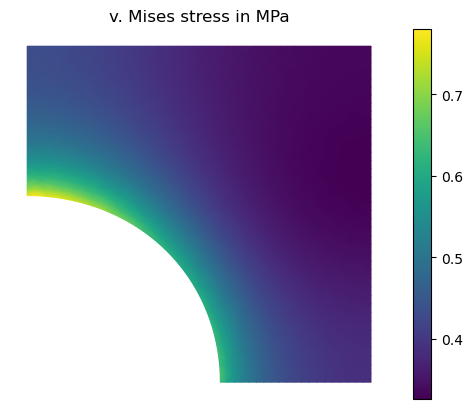

In [7]:
# Compute stress
sgb = basis.with_element(fem.ElementVector(element))
ui = basis.interpolate(u)
S = sgb.project(sigma(sym_grad(ui)))
Sxx = S[sgb.nodal_dofs[0]]
Sxy = S[sgb.nodal_dofs[1]]
Syy = S[sgb.nodal_dofs[3]]
Smises = np.sqrt(Sxx**2 + Syy**2 - Sxx*Syy + 3*Sxy**2)

# Save mesh
mesh.save(f"result_Rx={Rx}.vtk", point_data={"Displacement": u.reshape((-1, 2)), "Stress": S.reshape((-1,4))})

# Save results
inputs = np.stack([mesh.doflocs[0], mesh.doflocs[1], Rx * np.ones_like(mesh.doflocs[0])])
np.savetxt(f"data/inputs_Rx={Rx}.csv", inputs.T, delimiter=",", header="X,Y,R")
outputs = np.stack([Sxx, Syy, Sxy, Smises])
np.savetxt(f"data/outputs_Rx={Rx}.csv", outputs.T, delimiter=",", header="Sxx,Syy,Sxy, Smises")

# Compute deformed mesh
defmesh = copy.deepcopy(mesh)
defmesh.doflocs[0] += u[basis.nodal_dofs[0]]
defmesh.doflocs[1] += u[basis.nodal_dofs[1]]

# Plot results
p = plot(defmesh, Smises, colorbar=True, shading='gouraud', cmap="viridis")
p.set_title("v. Mises stress in MPa")
p.show()